In [5]:
import watson_nlp

In [1]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

# The raw data doesn't include the column headers. The headers are described at https://static.nhtsa.gov/odi/ffdd/cmpl/CMPL.txt
import_df = pd.read_csv('https://static.nhtsa.gov/odi/ffdd/cmpl/COMPLAINTS_RECEIVED_2020-2023.zip', sep='\t', header=None)

# we will only use a subset of the columns in our analysis
complaint_df = import_df[[0,3,4,11,19]]
complaint_df.rename(columns={0: 'Complaint_ID', 3: 'Make', 4: 'Model', 11: 'Component', 19: 'Description'}, inplace=True)
complaint_df.fillna({'Description' : ''}, inplace=True)  # to ensure all descriptions are proper strings for later analysis
complaint_df.astype({'Description': 'str'}, copy=False)


complaint_df.head()


/tmp/1000670000/ipykernel_569/1436377376.py:6: DtypeWarning: Columns (28,30,33,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  import_df = pd.read_csv('https://static.nhtsa.gov/odi/ffdd/cmpl/COMPLAINTS_RECEIVED_2020-2023.zip', sep='\t', header=None)
/tmp/1000670000/ipykernel_569/1436377376.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaint_df.rename(columns={0: 'Complaint_ID', 3: 'Make', 4: 'Model', 11: 'Component', 19: 'Description'}, inplace=True)
/tmp/1000670000/ipykernel_569/1436377376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Complaint_ID,Make,Model,Component,Description
0,1633301,HONDA,ACCORD,SERVICE BRAKES,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
1,1633302,HONDA,ACCORD,ELECTRICAL SYSTEM,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
2,1633303,HONDA,ACCORD,ENGINE,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN FROM 70MPH TO 40-50MPH,THERE WERE ANY CAR IN FRONT OF ME! I HAVE NOTHING ON MY WINDSHIELD! THERE WEREN'T ANY STOP OR TRAFFIC SIGN! SO HONDA STOP SAYING I AM DRIVING RECKLESSLY! FOR FEW SECOND I REGAINED CONTROL OF GAS, I HAVE TO SPEED UP MY CAR SO I DON'T GET REAR END, THEN EVERYTHING HAPPEN AGAIN, CAR DECIDED TO TAP BRAKE BY ITSELF. THIS HAPPEN ..."
3,1633304,FORD,EXPLORER,ELECTRICAL SYSTEM,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST RECENT EXPERIENCE INVOLVED HAVING TO JUMP START THE CAR AFTER SETTING 3 DAYS.
4,1633305,CHEVROLET,VOLT,SERVICE BRAKES,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, THE ADAPTIVE CRUISE CONTROL WILL NOT ENGAGE 25% OF THE TIME AND WILL DISENGAGE WITHOUT NOTICE. ""ADAPTIVE CRUISE CONTROL WILL APPEAR IN DIC. HOWEVER, THIS CREATES A SAFETY HAZARD AS YOU NEVER KNOW IF THE CAR WILL AUTOMATICALLY SLOW DOWN. I HAVE FILED CASE # 9-5379585813 WITH CHEVROLET AND BEEN TO FOUR DEALERS AND THEY REFUSE TO FIX THE PROBLEM. TH..."


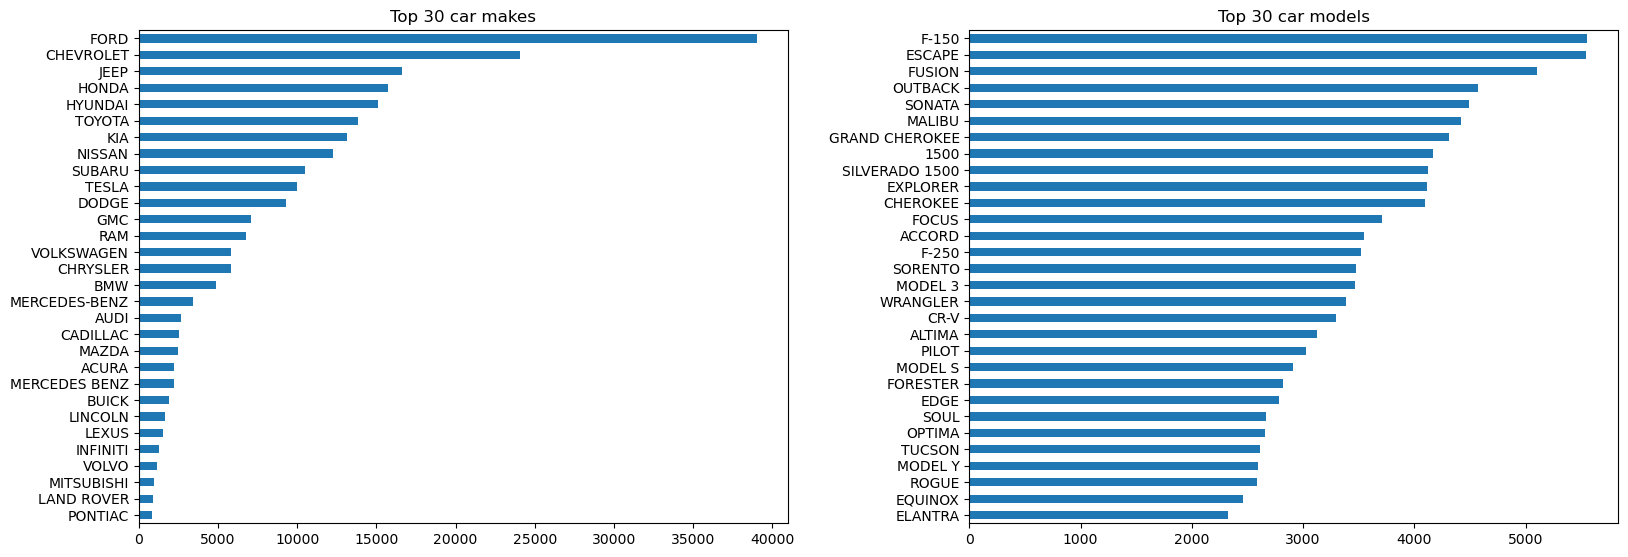

In [2]:
import matplotlib.pyplot as plt

figure, ((ax1, ax2)) = plt.subplots(ncols=2, figsize=(18,8))
figure.tight_layout(pad=10)
complaint_df['Make'].value_counts().head(30).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 30 car makes')
complaint_df['Model'].value_counts().head(30).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text('Top 30 car models')
plt.show()

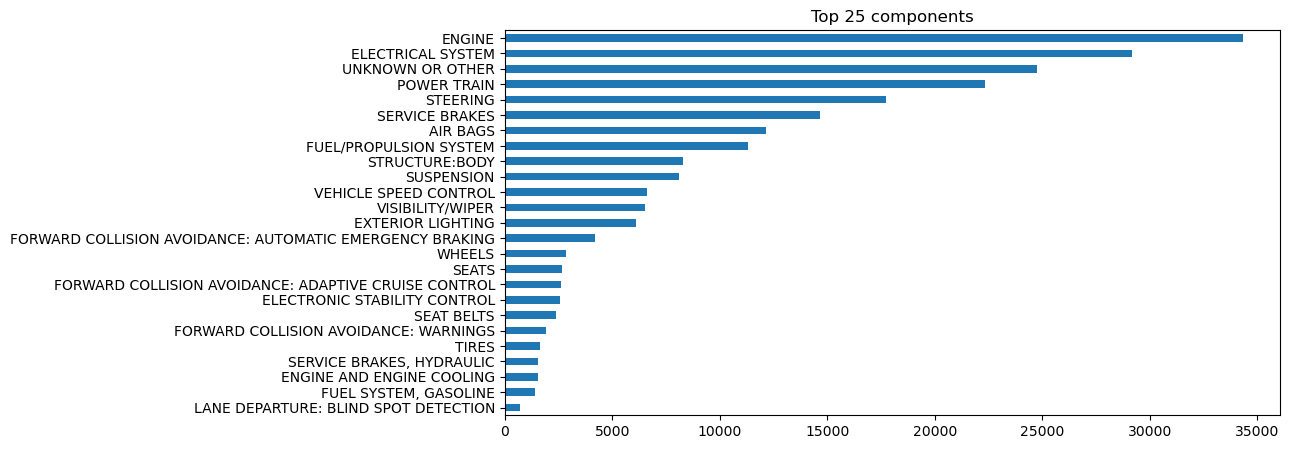

In [3]:
figure, (ax1) = plt.subplots(ncols=1, figsize=(10,5))
complaint_df['Component'].value_counts().head(25).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 25 components')
plt.show()


In [6]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
noun_phrases_model = watson_nlp.load('noun-phrases_rbr_en_stock')

In [7]:
stopwords = set(['FAILURE', 'VEHICLE', 'VEHICLES', 'PROBLEM', 'CAR', 'FORD', 'MANUFACTURER', 
                 'DEALER', 'CONSUMER', 'DRIVER', 'TIME', 'TIMES', 'ISSUE', 'RECALL'])


def extract_nouns(text):
    syntax_result = syntax_model.run(text, parsers=('lemma', 'part_of_speech'))
    # gather tokens that are nouns and have more than two characters (to avoid picking up some "control words" in the data)
    # collect the lemma instead of the surface form. This way, both "wheels" and "wheel" are collected as "wheel"
    nouns = [token['lemma'] for token in syntax_result.to_dict()['tokens'] if (
        (token['part_of_speech'] == 'POS_PROPN' or token['part_of_speech'] == 'POS_NOUN') and len(token['lemma']) > 2)] 
    # remove stopwords
    nouns = [noun for noun in nouns if noun.upper() not in stopwords]
    return list(set(nouns))  #if a noun occurs several times, we only want to pick it up once

def extract_nps(text):
    np_res = noun_phrases_model.run(text)
    # gather phrases that have more than two characters (to avoid picking up some "control words" in the data), and aren't one of the stopwords
    phrases = [phrase.span.text.lower() for phrase in np_res.noun_phrases if phrase.span.text.upper() not in stopwords and len(phrase.span.text) > 2]
    return list(set(phrases))

from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

# Returns a dataframe that contains Complaint_ID, Model and the Nouns found in the complaint description
# For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. 
# You can also use `apply` from `pandas` directly, i.e. `modelDF['Description'].apply(..)`
def createNounDF(modelDF):
    # extract nouns 
    keywords = modelDF['Description'].progress_apply(lambda x: extract_nouns(x))
    keywordDF = pd.DataFrame(keywords)
    keywordDF.rename(inplace=True, columns={'Description':'Nouns'})
    return modelDF[['Complaint_ID', 'Model']].merge(keywordDF, how='left', left_index=True, right_index=True)

# Returns a dataframe that contains Complaint_ID, Model and the Noun Phrases found in the complaint description
# For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. 
# You can also use `apply` from `pandas` directly, i.e. `modelDF['Description'].apply(..)`
def createNounPhraseDF(modelDF):
    # extract noun phrases
    keywords = modelDF['Description'].progress_apply(lambda x: extract_nps(x))
    keywordDF = pd.DataFrame(keywords)
    
    # Return a dataframe that contains Complaint_ID, Model and the noun phrases as 'Keywords' 
    keywordDF.rename(inplace=True, columns={'Description':'Noun Phrases'})
    return modelDF[['Complaint_ID', 'Model']].merge(keywordDF, how='left', left_index=True, right_index=True)


In [8]:
noun_df = createNounDF(complaint_df.query("Make == 'FORD'"))


  0%|          | 0/39020 [00:00<?, ?it/s]

In [9]:
noun_df.head()

,Complaint_ID,Model,Nouns
3,1633304,EXPLORER,"[experience, mode, sleep, day]"
26,1633327,F-350,"[oscillation, Co., video, curve, Road, bump, Lane, Death, front]"
28,1633329,ESCAPE,"[mile, transmission, gear, tow]"
48,1633349,FOCUS,"[Dot, Green, City, rubber, labor, Care, wear, December, Tire, credit, wheel, Firestone, Street, fee, bar, July, tire, installation, phone, scrap, Parkway, valve, total, affinity, Boulder, Auto, balance, lifetime, North, Fee, Valley, firestone, mile, warranty]"
57,1633358,F-150,[software]


In [10]:
noun_phrase_df = createNounPhraseDF(complaint_df.query("Make == 'FORD'"))

  0%|          | 0/39020 [00:00<?, ?it/s]

In [11]:
noun_phrase_df.head()

,Complaint_ID,Model,Noun Phrases
3,1633304,EXPLORER,"[deep sleep mode, recent experience, days]"
26,1633327,F-350,"[oscillation, lane road, video, curve, occur, mph, death wooble, forsyth co., minor bump, front]"
28,1633329,ESCAPE,"[miles, tow, pch, gears, transmission]"
48,1633349,FOCUS,"[miles, before mentioned tires, scrap tire, tires, bl p, boulder city parkway, new tire wheel balance labor, tire installation, credit, firestone complete auto care green valley, nevada, fee, north stephanie street, hbl dot#y9k5d8hk3210 tires prie, new tires, tire, july, primewell ps, mile warranty, phone, henderson, miles warranty, nevada recycling fee, lifetime rubber valve, total, boulder c..."
57,1633358,F-150,[new software]


In [12]:
noun_row_df = noun_df.explode('Nouns')
noun_phrase_row_df = noun_phrase_df.explode('Noun Phrases')

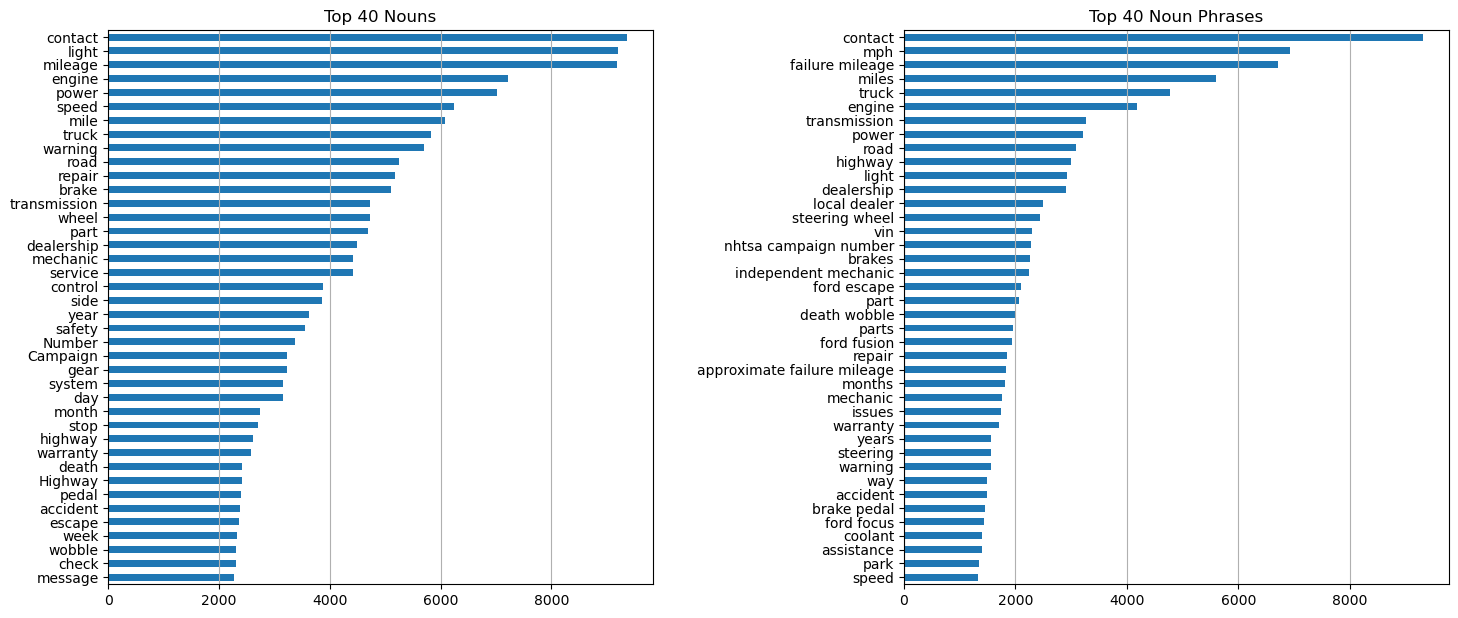

In [13]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
figure.tight_layout(pad=15)
noun_row_df['Nouns'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text('Top 40 Nouns')
ax1.xaxis.grid(True)
noun_phrase_row_df['Noun Phrases'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text('Top 40 Noun Phrases')
ax2.xaxis.grid(True)

plt.show()

In [14]:
!pip install fpgrowth_py

In [15]:
import fpgrowth_py.fpgrowth as fpgrowth

In [16]:
modelNounList = noun_row_df[['Model', 'Nouns']].values.tolist()
len(modelNounList)  # the total number of (model, noun) pairs

548925

In [17]:
min_support = 100 / len(modelNounList) 
min_support

0.00018217424966980917

In [ ]:
freqItemSet, rules = fpgrowth(modelNounList, minSupRatio=min_support, minConf=0.25)

In [ ]:
for rule in rules:
    if 'F-150' in rule[1]:
        print(rule)

In [ ]:
import plotly.express as px

# Collect the nouns found in the association rules for <model>. 
# Show the nouns in a tree map, sized by the rule confidence.
def show_rules_for_model(rules, model):
    modelDict = {}
    for rule in rules:
        if model in rule[1]:
            noun=next(iter(rule[0]))
            if model.lower() not in noun: # we don't want to include the model name itself in the word cloud
                modelDict[noun] = int(rule[2]*1000)
    df = pd.DataFrame.from_dict(modelDict, orient='index', columns=['Frequency'])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Term'}, inplace=True)
    fig = px.treemap(df, path=[df['Term']], values='Frequency')
    fig.update_traces(marker_colorbar_title_text="Correlated Terms with " + model)
    fig.update_traces(root_color="lightgrey")
    fig.update_traces(textinfo="label")
    fig.update_traces(insidetextfont_size=20)
    fig.show()
